In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
words = open("names.txt", 'r').read().splitlines()

In [25]:
chrs = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chrs)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [26]:
#build the dataset
def b_dataset(block_size,words):
    #predicting 4th character given the  three characters
    inputs , labels = [] , []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            inputs.append(context)
            labels.append(ix)
            # print(f"character {ch}")
            # print(''.join(itos[i] for i in context), '--->' , itos[ix])
            context = context[1:] + [ix] #crop the context and enter new character into the window
            # print(f"this is context {context}")
    inputs = torch.tensor(inputs)
    labels = torch.tensor(labels)
    return inputs, labels

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
block_size = 3

Xtr , Ytr = b_dataset(block_size, words[:n1])
Xval, Yval = b_dataset(block_size, words[n1:n2])
Xte , Yte = b_dataset(block_size, words[n2:])


In [28]:
#build embedding
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd),generator=g) #embedding in two dimension 
#hidden layer 1
W1 = torch.randn((n_embd*block_size,n_hidden),generator=g)
b1 = torch.randn(n_hidden,generator=g)
#hidden layer 2
W2 = torch.randn((n_hidden,vocab_size),generator=g)
b2 = torch.randn(vocab_size,generator=g)
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


11897


In [13]:
lr = torch.linspace(-3, 0, 1000)
lrs = 10**lr # 0.001 , 1

In [14]:
lri = []
lossi = []
stepi  = []

In [30]:
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):

    #creating mini batches
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb , Yb = Xtr[ix] , Ytr[ix] #batch X, Y

    #forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1) #concatenate the vectors
    hprecat = (embcat @ W1 + b1) #hidden layer pre activation
    h = torch.tanh(hprecat) #hidden layer
    logits = h @ W2 + b2 #output layer
    loss = F.cross_entropy(logits, Yb) #loss function

    print(loss.item())

    #backward pass
    for p in parameters:
        p.grad = None #setting all the gradients to none
    loss.backward() #get the gradient

    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 1000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


25.25912094116211
      0/ 200000: 25.2591
22.200979232788086
22.431224822998047
20.855037689208984
20.331586837768555
21.332700729370117
16.22193145751953
18.190128326416016
23.063594818115234
12.492579460144043
18.730003356933594
18.889280319213867
17.224037170410156
19.372161865234375
14.529326438903809
18.33435821533203
12.210017204284668
18.802574157714844
13.819263458251953
15.47482967376709
17.841291427612305
15.367897987365723
14.208395957946777
12.185880661010742
15.157777786254883
13.343993186950684
16.464757919311523
10.080406188964844
14.17970085144043
17.074058532714844
13.320263862609863
12.709410667419434
16.119667053222656
11.13002872467041
15.83936882019043
11.072625160217285
15.347127914428711
13.709275245666504
10.67841625213623
14.30717658996582
10.621699333190918
7.044297695159912
9.373655319213867
12.247559547424316
12.693537712097168
10.956225395202637
9.217615127563477
14.505070686340332
11.320295333862305
14.737457275390625
13.152801513671875
12.427151679992676

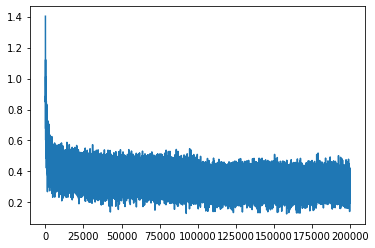

In [31]:
plt.plot(lossi)

In [150]:
#training split --> train the parameters (weights and biases)
#validation split  --> train the hyperaparameters 
                        #(lr, embeddings, size of hidden layers, number of hidden layers,regularization)
#test split --> evaluate the performance of the model 
                #You only get limited opportunity to test the trained model 
                #or else you would start to overfit. 

In [32]:
@torch.no_grad() # No need to maintain bookkeeping of gradient, we wont do loss.backward() 
def split_loss(split):
    x,y = {'train' : (Xtr, Ytr) , 'vali' : (Xval, Yval), 'test' : (Xte , Yte)}[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0],-1) #concatenate the vectors
    hprecat = (embcat @ W1 + b1) #hidden layer pre activation
    h = torch.tanh(hprecat) #hidden layer
    logits = h @ W2 + b2 #output layer
    loss = F.cross_entropy(logits, y) #loss function
    print(split, loss.item())
split_loss('train')
split_loss('vali')

train 2.1210579872131348
vali 2.1827447414398193


In [33]:
#sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(10):
    out = []
    context = [0] * block_size
    while True:
        #forward pass through neural network
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits , dim=1)

        #sample from the distribution
        ix = torch.multinomial(probs, num_samples=1,generator=g).item()



        #shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(context)

        # if we sample the special '.' token, break        
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

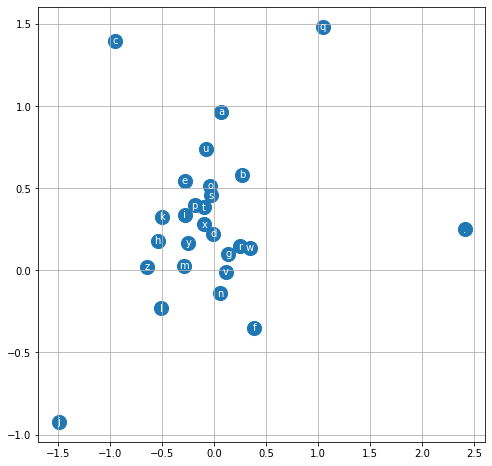

In [21]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data , s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')
